### Description
This code is creates a simple comparison between the kinematic measurements of an NFW+Chameleon profile, whether or not an MGE is used.

Some of the subfunctions are used from within galkin/kinematicsAPI rather than kinematicsAPI itself so that I can experiment with some of the MGE settings

In [1]:
#some imports
__author__ = 'mgomer'
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.GalKin.galkin import Galkin
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.multi_gauss_expansion as mge
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


In [2]:
#a few functions to make different settings more readable, galkin settings
center_x,center_y=0,0

def mge_mass(lens_model_list,kwargs_mass):
    #this function creates an MGE mass model using the same function as galkin uses
    ncomp_max=30
    LensMod = LensModel(lens_model_list)
    LensAn = LensProfileAnalysis(LensMod)
    amps, sigmas, center_x_mge, center_y_mge=LensAn.multi_gaussian_lens(kwargs_mass, center_x=center_x, 
                                                                      center_y=center_y, model_bool_list=None, 
                                                                      n_comp=ncomp_max)
    lens_model_list_mge = ['MULTI_GAUSSIAN_KAPPA']
    kwargs_mass_mge = [{'amp': amps, 'sigma': sigmas}]
    return lens_model_list_mge,kwargs_mass_mge
def mge_light(lens_light_model_list,kwargs_light,r_h):
    #this function does the same for a light model. 
    #It is mostly copied from lenstronomy.Analysis.light_profile.multi_gaussian_decomposition
    #except I allow r_h to be set manually for experimentation
    ncomp_max=30
    LensLightModel=LightModel(light_model_list=lens_light_model_list)
    lensLightProfile = LightProfileAnalysis(light_model=LensLightModel)
    r_array = np.logspace(-3, 3, 200) * r_h * 2
    flux_r = lensLightProfile.radial_light_profile(r_array, kwargs_light, center_x=center_x, center_y=center_y,
                                           model_bool_list=None)
    amps, sigmas, norm = mge.mge_1d(r_array, flux_r, N=ncomp_max)
    print('No. of components used: ',np.shape(amps))
    lens_light_model_list_mge = ['MULTI_GAUSSIAN']
    kwargs_light_mge = [{'amp': amps, 'sigma': sigmas}]
    return lens_light_model_list_mge,kwargs_light_mge

#function to plot sigma
def sigma_r_plot(result_,ax=None,label=None,color='C0',linestyle='-'):
    if ax==None: #make new figure
        fig,ax=plt.subplots(1,1,figsize=(7,7))
    plot_r=result_['plot_r']
    sig_proj=result_['sig_proj']
    ax.semilogx(plot_r,sig_proj,label=label,color=color,linestyle=linestyle,alpha=0.7)
    vel_disp_ap=result_['v_disp_aperture']
    ax.scatter(rbins_aperture[1:],vel_disp_ap,color=color)
    ax.set_ylim([200,300])
    ax.set_ylabel(r'$\sigma_v$',fontsize=16)
    ax.set_xlabel(r'R [arcsec]',fontsize=16)
    plt.legend()

#galkin model settings:
cosmo = FlatLambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=0.3)
anisotropy_type = 'OM'
kwargs_numerics = {'interpol_grid_num': 5000, 'log_integration': True,
                          'max_integrate': 4000, 'min_integrate': 0.001}
psf_fwhm=0.7
kwargs_seeing={'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}
rbins_aperture= np.linspace(0, 2, 4)
kwargs_aperture = {'aperture_type': 'IFU_shells', 'r_bins':rbins_aperture, 'center_ra': center_x,'center_dec':center_y}

z_l=0.25
z_s=0.6
lensCosmo = LensCosmo(z_l, z_s, cosmo=cosmo)
kwargs_cosmo = {'d_d': lensCosmo.dd, 'd_s': lensCosmo.ds, 'd_ds': lensCosmo.dds}
kwargs_anisotropy = {'r_ani':2} #r_ani set to the effective radius of the Sersic used for the Chameleon, such that a_ani=1
plot_r = np.logspace(-2, 2, 200) 

def galkin_quantities(lens_model_list, lens_light_model_list,kwargs_mass,kwargs_light,kwargs_anisotropy):
    #this function creates the galkin instance and calculates sigma_v
    #also uses anisotropy_type, kwargs_aperture, kwargs_seeing,kwargs_cosmo, kwargs_numerics, plot_r
    print('Using these models for v_disp measurement:')
    print(lens_model_list,lens_light_model_list)
    galkin=Galkin({'mass_profile_list': lens_model_list, 'light_profile_list': lens_light_model_list,
                   'anisotropy_model': anisotropy_type}, kwargs_aperture=kwargs_aperture,
                  kwargs_psf=kwargs_seeing, analytic_kinematics=False,
                  kwargs_cosmo=kwargs_cosmo, kwargs_numerics=kwargs_numerics)
    sig_proj=np.zeros_like(plot_r)
    for r_index, rad in enumerate(plot_r):
        sig_proj[r_index]=np.sqrt(galkin.numerics.sigma_s2_project(rad,kwargs_mass,kwargs_light,kwargs_anisotropy)[0])/1000
        
    LensLightModel=LightModel(light_model_list=lens_light_model_list)
    light_3d=LensLightModel.light_3d(plot_r, kwargs_light)
    v_disp_aperture = galkin.dispersion_map(kwargs_mass, kwargs_light, kwargs_anisotropy,
                            num_kin_sampling=2000)
    return {'plot_r': plot_r, 'v_disp_aperture': v_disp_aperture, 'sig_proj': sig_proj,'light_3d': light_3d}


Using these models for v_disp measurement:
['CHAMELEON', 'NFW_ELLIPSE'] ['CHAMELEON']


/home/gomer/miniconda3/envs/lenstro_branch/lib/python3.8/site-packages/lenstronomy-1.9.0-py3.8.egg/lenstronomy/GalKin/light_profile.py:112: RuntimeWarning: invalid value encountered in sqrt
  stop = np.log10(np.maximum(np.sqrt(self._max_interpolate**2 - R**2), self._min_interpolate + 0.00001))


No. of components used:  (30,)
Using these models for v_disp measurement:
['MULTI_GAUSSIAN_KAPPA'] ['MULTI_GAUSSIAN']


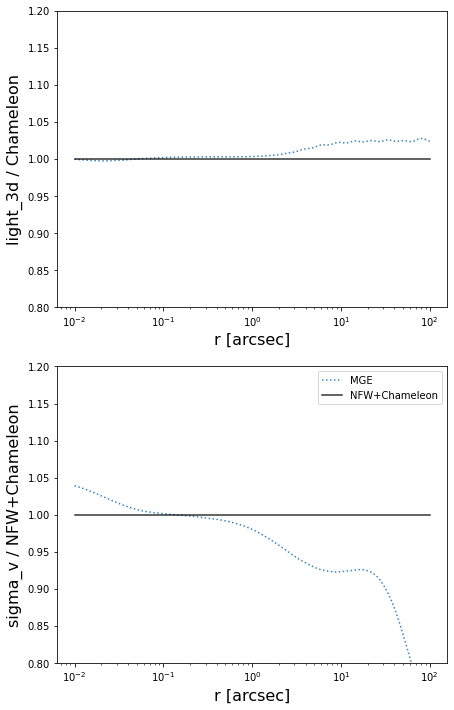

In [3]:
#This cell calculates sigma_v and makes plots with radius
e1=0.1
#this chameleon is close to a Sersic with n=4, r_eff=2
kwargs_chameleon={'alpha_1': 0.84, 'w_c': 0.02, 'w_t': 2.45, 'e1': e1, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
kwargs_nfw={'Rs': 11, 'alpha_Rs': 0.58, 'e1': e1, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
lens_model_list=['CHAMELEON', 'NFW_ELLIPSE']
kwargs_mass=[kwargs_chameleon, kwargs_nfw]

e1_light=0.1 #if this is changed to 0, profiles match.
lens_light_model_list=['CHAMELEON']
kwargs_light=[{'amp': 1.0, 'w_c': 0.02, 'w_t': 2.45, 'e1': e1_light, 'e2': 0.0, 'center_x': 0, 'center_y': 0}]

#KINEMATICS 
result_orig= galkin_quantities(lens_model_list, lens_light_model_list,kwargs_mass,kwargs_light,kwargs_anisotropy)
#MGE: comment out result_mgemass or result_mge lines to calculate those instead of MGE for both light and mass. I found that only light produced a discrepancy, but for these figures I have MGEs of both
lens_model_list_mge,kwargs_mass_mge=mge_mass(lens_model_list,kwargs_mass)
# result_mgemass= galkin_quantities(lens_model_list_mge, lens_light_model_list,kwargs_mass_mge,kwargs_light,kwargs_anisotropy)
lens_light_model_list_mge,kwargs_light_mge=mge_light(lens_light_model_list,kwargs_light,r_h=2.0)
# result_mgelight= galkin_quantities(lens_model_list, lens_light_model_list_mge,kwargs_mass,kwargs_light_mge,kwargs_anisotropy)
result_mgeboth= galkin_quantities(lens_model_list_mge, lens_light_model_list_mge,kwargs_mass_mge,kwargs_light_mge,kwargs_anisotropy)

fig,ax=plt.subplots(2,1,figsize=(7,12))
ax[0].semilogx(plot_r,result_mgeboth['light_3d']/result_orig['light_3d'],label='MGE',linestyle=':',alpha=0.9)
ax[1].semilogx(plot_r,result_mgeboth['sig_proj']/result_orig['sig_proj'],label='MGE',linestyle=':',alpha=0.9)

ax[0].semilogx(plot_r,result_orig['light_3d']/result_orig['light_3d'],label='NFW+Chameleon',color='k',linestyle='-',alpha=0.8)
ax[0].set_ylabel(r'light_3d / Chameleon',fontsize=16)
ax[0].set_xlabel(r'r [arcsec]',fontsize=16)
ax[0].set_ylim([0.8,1.2])
ax[0].axvline()

ax[1].semilogx(plot_r,result_orig['sig_proj']/result_orig['sig_proj'],label='NFW+Chameleon',color='k',linestyle='-',alpha=0.8)
ax[1].set_ylabel(r'sigma_v / NFW+Chameleon',fontsize=16)
ax[1].set_xlabel(r'r [arcsec]',fontsize=16)
ax[1].set_ylim([0.8,1.2])
plt.legend()
plt.show()



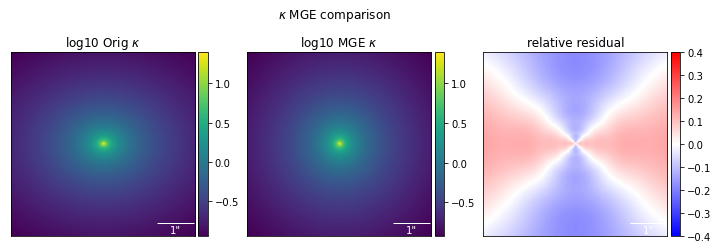

In [4]:
#this cell makes and plots kappa maps
def kappamap_2d(lens_model_list, kwargs_lens):
    #make array for kappamap
    LensMod = LensModel(lens_model_list)
    delta_pix=0.01
    n_pix=500
    kwargs_pixel_grid_image = {'nx':n_pix,'ny':n_pix,'transform_pix2angle':np.array([[1, 0],[0, 1]])*delta_pix,'ra_at_xy_0':-n_pix/2.*delta_pix,'dec_at_xy_0':-n_pix/2.*delta_pix}
    Grid = PixelGrid(**kwargs_pixel_grid_image)
    x_coords, y_coords = Grid.pixel_coordinates
    kappa_grid=LensMod.kappa(x_coords,y_coords,kwargs_lens)
    return kappa_grid

def plot_map(array, cmap, fig, ax, pix_size=0.01,vmin=None,vmax=None):
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    im=ax.imshow(array,cmap=cmap,vmin=vmin,vmax=vmax)
    fig.colorbar(im, cax=cax, orientation='vertical')
    scalebar = AnchoredSizeBar(ax.transData,
                           1/pix_size, '1"', 'lower right', 
                           pad=pix_size,
                           color='white',
                           frameon=False,
                           size_vertical=pix_size,)
    ax.add_artist(scalebar)
    plt.setp(ax, xticks=[], xlabel=None,yticks=[], ylabel=None)
    
fig2,ax2=plt.subplots(1,3,figsize=(12,4))
fig2.suptitle(r'$\kappa$ MGE comparison')
kappa_orig=kappamap_2d(lens_model_list, kwargs_mass)
kappa_mge=kappamap_2d(lens_model_list_mge, kwargs_mass_mge)
resid=(kappa_orig-kappa_mge)/kappa_orig
plot_map(np.log10(kappa_orig),None, fig2, ax2[0])
ax2[0].set_title(r'log10 Orig $\kappa$')
plot_map(np.log10(kappa_mge),None, fig2, ax2[1])
ax2[1].set_title(r'log10 MGE $\kappa$')
plot_map(resid,'bwr', fig2, ax2[2],vmin=-.4, vmax=0.4)
ax2[2].set_title(r'relative residual')
plt.show()